# Mantenimiento proactivo: predicción de fallas con ML

Una empresa tiene una flota de dispositivos que transmiten lecturas diarias de sensores. Les gustaría crear una solución de mantenimiento predictivo para identificar de forma proactiva cuándo se debe realizar el mantenimiento. Este enfoque promete ahorros de costos con respecto al mantenimiento preventivo de rutina o basado en el tiempo, porque las tareas se realizan sólo cuando están justificadas.

El objetivo consiste en construir un modelo predictivo utilizando el aprendizaje automático para predecir la probabilidad de que falle un dispositivo. Al construir este modelo, asegúrese de minimizar los falsos positivos y los falsos negativos. La columna que está intentando predecir se llama falla con valor binario 0 para no falla y 1 para falla.


Fuente: https://www.kaggle.com/code/ahmettalhabektas/proactive-maintenance-predicting-failures-with-ml

# 1. Cragar la librerías necesarias

In [425]:
## Pandas para manipular datos
import pandas as pd

## Matplotlib para graficar resultados
import matplotlib.pyplot as plt
%matplotlib inline
## Seaborn para visualización de datos
import seaborn as sns
## Numpy para las operaciones numéricas
import numpy as np
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


## Importando los algoritmos de ML supervisado
from sklearn.naive_bayes import GaussianNB, BernoulliNB  # For binary classification
##from sklearn.naive_bayes import MultinomialNB  # For multi-class classification
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
## Support Vector Machine
from sklearn.svm import SVC
## Árbol de decisión
from sklearn.tree import DecisionTreeClassifier
## Regresión logística
from sklearn.linear_model import LogisticRegression
##from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting classifier

## Métricas para evaluación de modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

## Herramienta para seprar datos de entrenamiento y testeo (validación)
from sklearn.model_selection import train_test_split

# 2. Lectura de datos

In [426]:
## Definir acceso al Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [427]:
## Define la ruta de acceso y archivo con datos
path = '/content/drive/MyDrive/AA - Salfa/Casos/'
filename = 'DatosFallas-V1.xlsx'
df = pd.read_excel(path+filename)

In [428]:
df.head()

,Fecha,Dispositivo,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 8,Metrica 9
0,2023-01-01 00:00:00,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,2023-01-01 00:00:00,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2023-01-01 00:00:00,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2023-01-01 00:00:00,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2023-01-01 00:00:00,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


# Análisis Exploratorio de Datos (EDA)

Entender el comportamiento de cada variable individualmente calculando recuentos de frecuencia, visualizando las distribuciones, etc. También las relaciones entre las diversas combinaciones de las variables predictoras y de respuesta creando diagramas de dispersión, correlaciones, etc.

- Comprender qué variables podrían ser importantes para predecir la Y (respuesta);
- Generar insights que nos permitan una mayor comprensión del contexto y desempeño del negocio.

EDA suele ser parte de cada proyecto de aprendizaje automático/modelado predictivo, especialmente con conjuntos de datos tabulares.

In [429]:
## Entrega la cantidad de filas y columnas
df.shape

(124494, 12)

In [430]:
df[df.duplicated(keep=False)]

,Fecha,Dispositivo,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 8,Metrica 9
101334,2023-10-07 00:00:00,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0
101335,2023-10-07 00:00:00,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0


Hay un sólo registro (fila) duplicado

In [431]:
## Borra las filas duplicadas
df.drop_duplicates(inplace=True)
df.shape

(124493, 12)

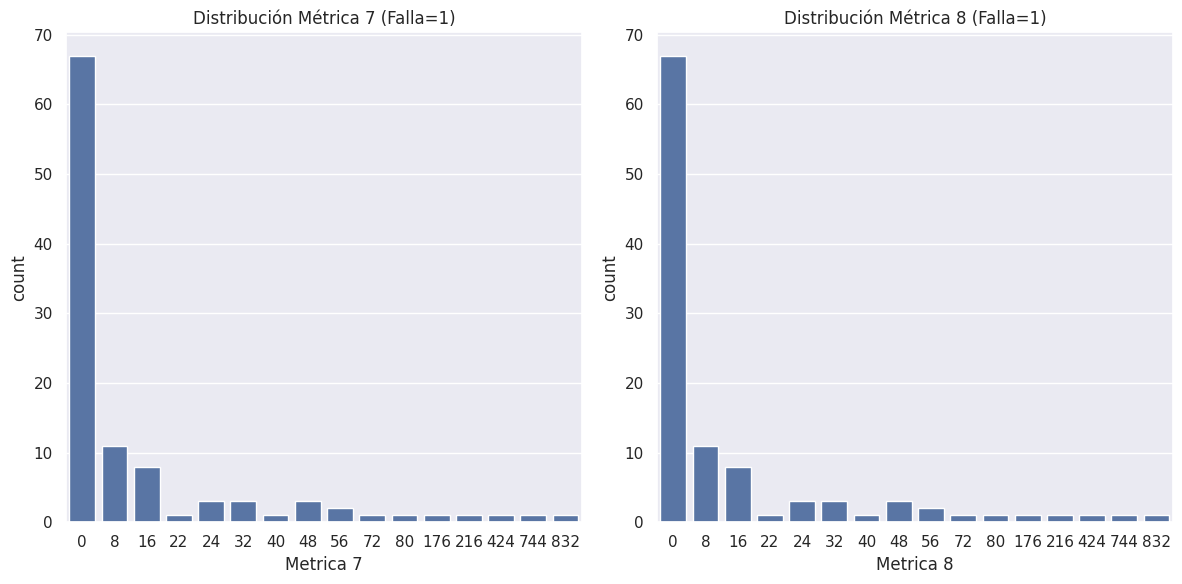

In [432]:
## Creamos dos gráficos
plt.figure(figsize=(12, 6))
##
## Graficamos la distribución Métrica 7
plt.subplot(1, 2, 1)
sns.countplot(x='Metrica 7', data=df.loc[df['Falla'] == 1])
plt.title('Distribución Métrica 7 (Falla=1)')
##
## Graficamos la distribución de Métrica 8
plt.subplot(1, 2, 2)
sns.countplot(x="Metrica 8", data=df.loc[df["Falla"] == 1])
plt.title('Distribución Métrica 8 (Falla=1)')
##
## Ajustamos el layout
plt.tight_layout()
##
## Mostramos los gráficos
plt.show()

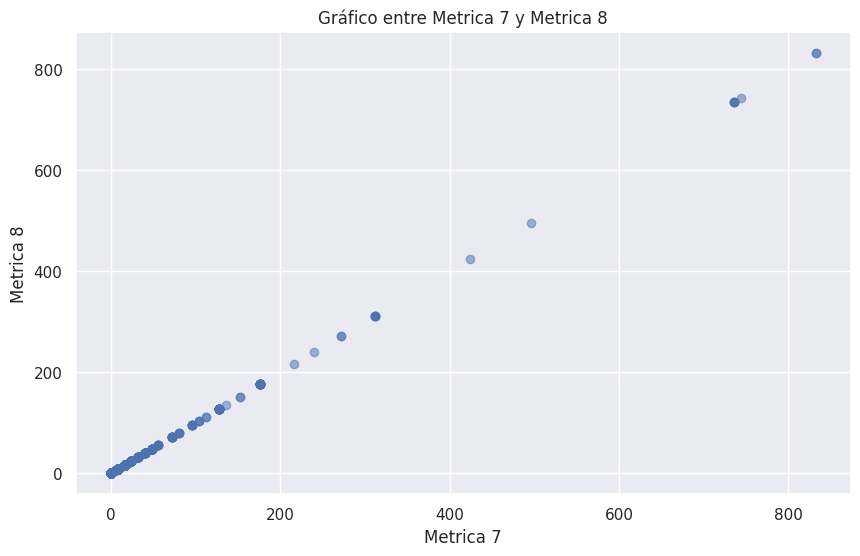

In [433]:
## Grafica dos métricas
plt.figure(figsize=(10, 6))
plt.scatter(df['Metrica 7'], df['Metrica 8'], alpha=0.5)
plt.title('Gráfico entre Metrica 7 y Metrica 8')
plt.xlabel('Metrica 7')
plt.ylabel('Metrica 8')
plt.grid(True)
plt.show()

Al parecer hay muchos datos concentrados al inición de los valores, lo cual genera distribuciones cargadas hacia los valores iniciales.

Entonces, se rectifican los valores realizando una transformación logoritmica de ellos

In [434]:
for num in ["2","3","4","7","8","9"]:
    df[f'Metrica {num}'] = np.log1p(df[f'Metrica {num}'])

In [435]:
df.head()

,Fecha,Dispositivo,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 8,Metrica 9
0,2023-01-01 00:00:00,S1F01085,0,215630672,4.025352,0.000000,3.970292,6,407438,0.0,0.0,2.079442
1,2023-01-01 00:00:00,S1F0166B,0,61370680,0.000000,1.386294,0.000000,6,403174,0.0,0.0,0.000000
2,2023-01-01 00:00:00,S1F01E6Y,0,173295968,0.000000,0.000000,0.000000,12,237394,0.0,0.0,0.000000
3,2023-01-01 00:00:00,S1F01JE0,0,79694024,0.000000,0.000000,0.000000,6,410186,0.0,0.0,0.000000
4,2023-01-01 00:00:00,S1F01R2B,0,135970480,0.000000,0.000000,0.000000,15,313173,0.0,0.0,1.386294


Hay una fuerte correlación entre la métrica 7 y 8, por lo cual no agrega ninguna información manejar las dos. Se procede a eliminar la metrica 8

In [436]:
df.drop("Metrica 8", axis = 1, inplace = True)

## Se resumen los datos disponibles

In [437]:
def summarize_data(df):
    print("Número de filas y columnas:", df.shape)
    print("\nColumnas de datos:", df.columns)
    print("\nTipo de datos y valores perdidos:")
    print(df.info())
    print("\nResumen de las columnas numéricas:")
    print(df.describe())
    print("\nValores perdidos:")
    print(df.isnull().sum())
    print("\nValores únicos en la columna 'failure':")
    print(df['Falla'].value_counts())

## Llama la función de resumen
summarize_data(df)

Número de filas y columnas: (124493, 11)

Columnas de datos: Index(['Fecha', 'Dispositivo', 'Falla', 'Metrica 1', 'Metrica 2', 'Metrica 3',
       'Metrica 4', 'Metrica 5', 'Metrica 6', 'Metrica 7', 'Metrica 9'],
      dtype='object')

Tipo de datos y valores perdidos:
<class 'pandas.core.frame.DataFrame'>
Index: 124493 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Fecha        124493 non-null  object 
 1   Dispositivo  124493 non-null  object 
 2   Falla        124493 non-null  int64  
 3   Metrica 1    124493 non-null  int64  
 4   Metrica 2    124493 non-null  float64
 5   Metrica 3    124493 non-null  float64
 6   Metrica 4    124493 non-null  float64
 7   Metrica 5    124493 non-null  int64  
 8   Metrica 6    124493 non-null  int64  
 9   Metrica 7    124493 non-null  float64
 10  Metrica 9    124493 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 11.4+ MB
No

Revisamos cuántos dispositivos estamos monitoreando, primero que nos entregue la columna de los nombres de los dispositivos

In [438]:
df["Dispositivo"]

,Dispositivo
0,S1F01085
1,S1F0166B
2,S1F01E6Y
3,S1F01JE0
4,S1F01R2B
...,...
124489,Z1F0MA1S
124490,Z1F0Q8RT
124491,Z1F0QK05
124492,Z1F0QL3N


In [439]:
df

,Fecha,Dispositivo,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9
0,2023-01-01 00:00:00,S1F01085,0,215630672,4.025352,0.000000,3.970292,6,407438,0.000000,2.079442
1,2023-01-01 00:00:00,S1F0166B,0,61370680,0.000000,1.386294,0.000000,6,403174,0.000000,0.000000
2,2023-01-01 00:00:00,S1F01E6Y,0,173295968,0.000000,0.000000,0.000000,12,237394,0.000000,0.000000
3,2023-01-01 00:00:00,S1F01JE0,0,79694024,0.000000,0.000000,0.000000,6,410186,0.000000,0.000000
4,2023-01-01 00:00:00,S1F01R2B,0,135970480,0.000000,0.000000,0.000000,15,313173,0.000000,1.386294
...,...,...,...,...,...,...,...,...,...,...,...
124489,2023-02-11 00:00:00,Z1F0MA1S,0,18310224,0.000000,0.000000,0.000000,10,353705,2.197225,0.000000
124490,2023-02-11 00:00:00,Z1F0Q8RT,0,172556680,4.574711,4.682131,1.609438,11,332792,0.000000,2.639057
124491,2023-02-11 00:00:00,Z1F0QK05,0,19029120,8.483223,0.000000,0.000000,11,350410,0.000000,0.000000
124492,2023-02-11 00:00:00,Z1F0QL3N,0,226953408,0.000000,0.000000,0.000000,12,358980,0.000000,0.000000


Ahora los dispositivos diferentes existentes en el monitoreo

**Nueva Características**

Creamos la características llamada 'device_model' que contiene los diferentes dispositivos (4 primeros caractéres) existentes en el monitoreo, y nos muestra la cantidad de registros asociados

In [440]:
df["Modelo_Dispositivo"] = df["Dispositivo"].apply(lambda x : x[:4])
df["Modelo_Dispositivo"].value_counts()

,count
Modelo_Dispositivo,
S1F0,33168
W1F0,23294
S1F1,21689
W1F1,19974
Z1F0,18869
Z1F1,7248
Z1F2,251


Creamos otra variable con los cuatro segundos caractéres de los nombre de los dispositivos

In [441]:
df["Resto_Dispositivo"] = df["Dispositivo"].apply(lambda x : x[4:])
df["Resto_Dispositivo"].value_counts()[:20]

,count
Resto_Dispositivo,
QLC1,304
KYCR,304
E9EP,304
EGMT,304
FGBQ,304
FP0C,304
GCED,304
GGPP,304
5X69,304


Ahora eliminamos la columna 'device' ya que fue separada en dos diferentes ('device_model'y 'device_rest')

In [442]:
df.drop("Dispositivo",axis=1,inplace=True)

In [443]:
df

,Fecha,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9,Modelo_Dispositivo,Resto_Dispositivo
0,2023-01-01 00:00:00,0,215630672,4.025352,0.000000,3.970292,6,407438,0.000000,2.079442,S1F0,1085
1,2023-01-01 00:00:00,0,61370680,0.000000,1.386294,0.000000,6,403174,0.000000,0.000000,S1F0,166B
2,2023-01-01 00:00:00,0,173295968,0.000000,0.000000,0.000000,12,237394,0.000000,0.000000,S1F0,1E6Y
3,2023-01-01 00:00:00,0,79694024,0.000000,0.000000,0.000000,6,410186,0.000000,0.000000,S1F0,1JE0
4,2023-01-01 00:00:00,0,135970480,0.000000,0.000000,0.000000,15,313173,0.000000,1.386294,S1F0,1R2B
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2023-02-11 00:00:00,0,18310224,0.000000,0.000000,0.000000,10,353705,2.197225,0.000000,Z1F0,MA1S
124490,2023-02-11 00:00:00,0,172556680,4.574711,4.682131,1.609438,11,332792,0.000000,2.639057,Z1F0,Q8RT
124491,2023-02-11 00:00:00,0,19029120,8.483223,0.000000,0.000000,11,350410,0.000000,0.000000,Z1F0,QK05
124492,2023-02-11 00:00:00,0,226953408,0.000000,0.000000,0.000000,12,358980,0.000000,0.000000,Z1F0,QL3N


**Histogramas de fallas y no fallas**

Construimos un histograma de la cantidad de fallas y no fallas por dispositivo

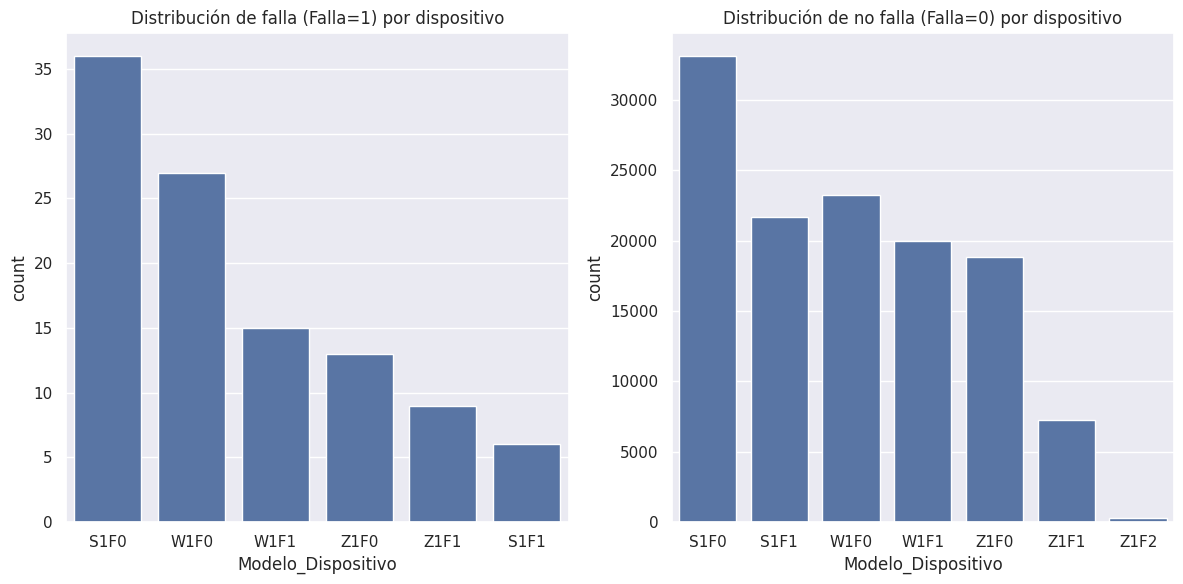

In [444]:
## Creamos dos gráficos
plt.figure(figsize=(12, 6))
## Graficamos la distribución (histograma) de las fallas por dispositivos (failure=1)
plt.subplot(1, 2, 1)
sns.countplot(x='Modelo_Dispositivo', data=df.loc[df['Falla'] == 1])
plt.title('Distribución de falla (Falla=1) por dispositivo')

## Graficamos la distribución de la no falla (failure=0) por dispositivo
plt.subplot(1, 2, 2)
sns.countplot(x="Modelo_Dispositivo", data=df.loc[df["Falla"] == 0])
plt.title('Distribución de no falla (Falla=0) por dispositivo')

## Ajustamos el layout
plt.tight_layout()

## Mostramos los gráficos
plt.show()

Al parecer el dispositivo Z1F2 presentan sólo casos de no falla, lo cual no nos permite generar la clasificación en forma adecuada (no tiene datos de fallas).

Entonces, decidimos eliminar las filas asociadas a dicho dispositivo

In [445]:
df.drop(df.loc[df["Modelo_Dispositivo"]=="Z1F2"].index,axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)
df.tail()

,Fecha,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9,Modelo_Dispositivo,Resto_Dispositivo
124237,2023-02-11 00:00:00,0,18310224,0.000000,0.000000,0.000000,10,353705,2.197225,0.000000,Z1F0,MA1S
124238,2023-02-11 00:00:00,0,172556680,4.574711,4.682131,1.609438,11,332792,0.000000,2.639057,Z1F0,Q8RT
124239,2023-02-11 00:00:00,0,19029120,8.483223,0.000000,0.000000,11,350410,0.000000,0.000000,Z1F0,QK05
124240,2023-02-11 00:00:00,0,226953408,0.000000,0.000000,0.000000,12,358980,0.000000,0.000000,Z1F0,QL3N
124241,2023-02-11 00:00:00,0,17572840,0.000000,0.000000,0.000000,10,351431,0.000000,11.156265,Z1F0,QLC1


Note que de los 124.494 datos originales (filas), debido a la eliminacón de duplicados y ahora de dispositivos sin fallas sólo quedan 124.242 filas

**Entendiendo device_rest**

Ahora queremos saber la distribución asociada a la característica devide_rest, entonces graficamos para el caso de fallas solamente (Falla=1)

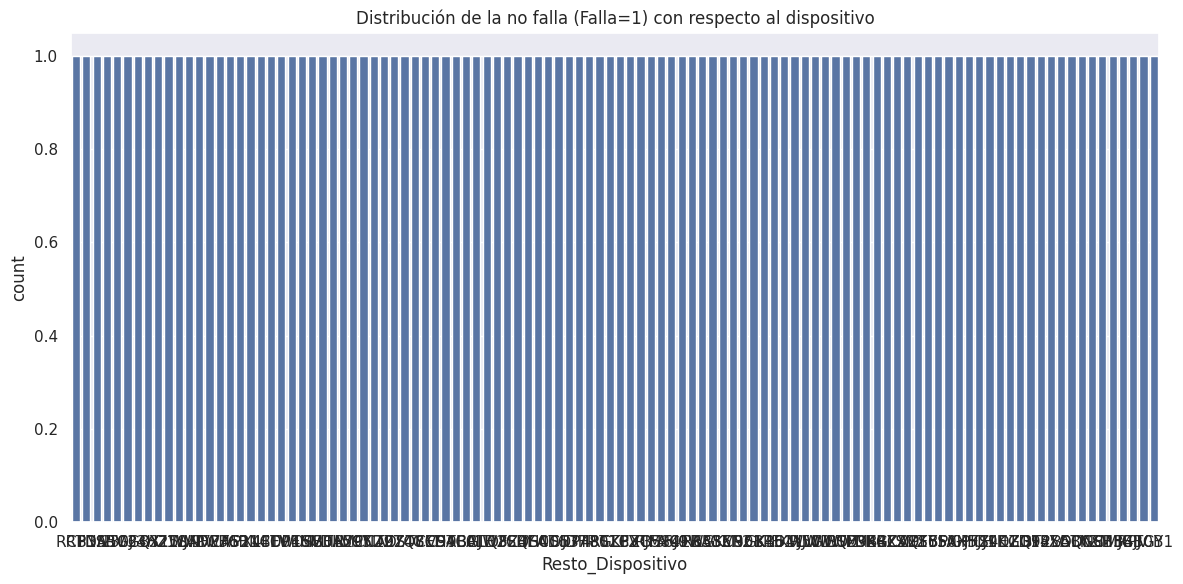

In [446]:
## Crea el gráfico para este análisis
plt.figure(figsize=(12, 6))
sns.countplot(x="Resto_Dispositivo", data=df.loc[df["Falla"] == 1])
plt.title('Distribución de la no falla (Falla=1) con respecto al dispositivo')

plt.tight_layout()

plt.show()

La verdad no entrega mayor información, ya que no presenta una cantidad de más de un dato en cuento a las fallas. Por esta razón, decidimos eliminar esta variable

In [447]:
df.drop("Resto_Dispositivo", axis = 1, inplace = True)
df.sample(5)

,Fecha,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9,Modelo_Dispositivo
6465,2023-06-01 00:00:00,0,143365968,8.756682,0.0,0.000000,13,191563,0.0,0.0,W1F0
71836,4/19/2023,0,35963640,0.000000,0.0,1.945910,9,256829,0.0,0.0,S1F0
76036,4/30/2023,0,153137128,0.000000,0.0,0.000000,4,9,0.0,0.0,W1F1
118427,2023-12-09 00:00:00,0,83367248,0.000000,0.0,0.000000,10,319089,0.0,0.0,S1F0
51137,2023-11-03 00:00:00,0,201601000,0.000000,0.0,2.197225,9,169543,0.0,0.0,S1F0


In [448]:
df.shape

(124242, 11)

## Histograma de las diferentes características

Distribución para no falla (Falla = 0)


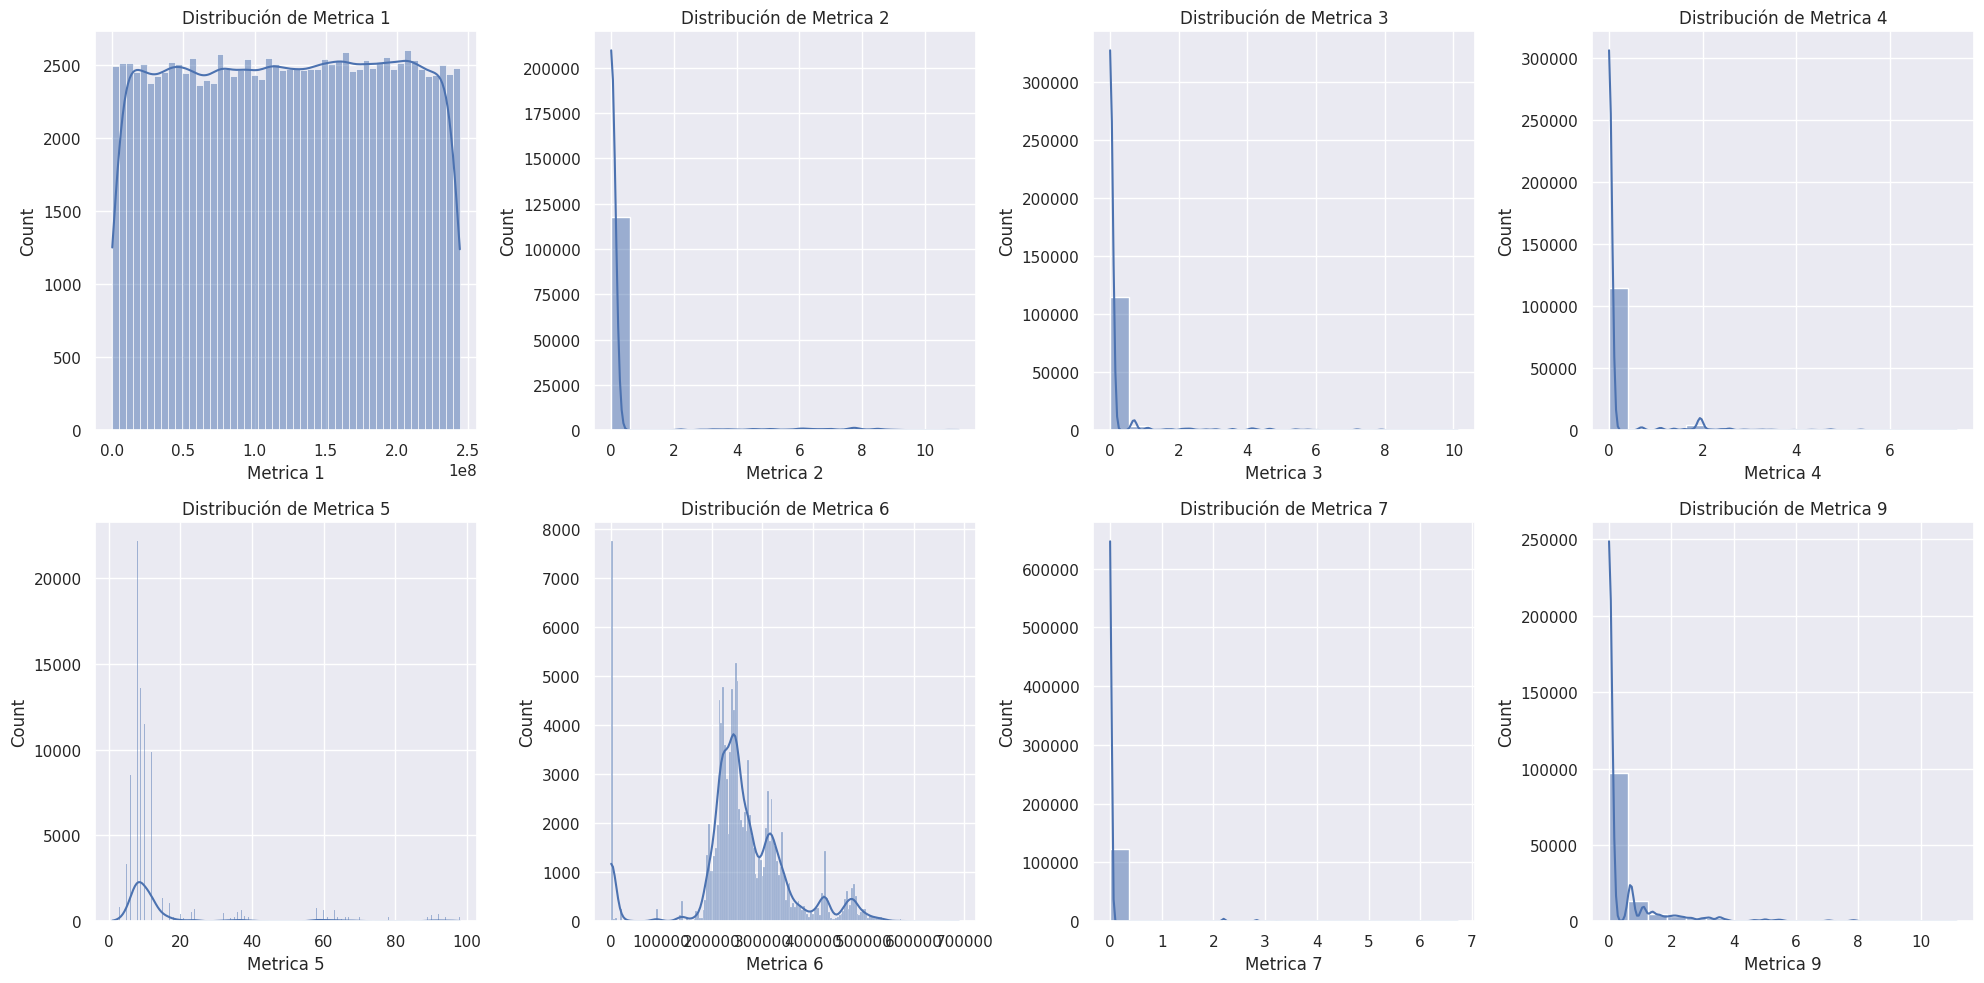

In [449]:
## Crea el histograma de las diferentes métricas
## considera el caso de las no falla (failure = 0)
plt.figure(figsize=(4*5, 2*5))
print("Distribución para no falla (Falla = 0)")
mask = df.Falla == 0
for i, col in enumerate(['Metrica 1', 'Metrica 2', 'Metrica 3', 'Metrica 4', 'Metrica 5', 'Metrica 6', 'Metrica 7', 'Metrica 9']):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=df.loc[mask], x=col, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()

Distribución para fallas (failure = 1)


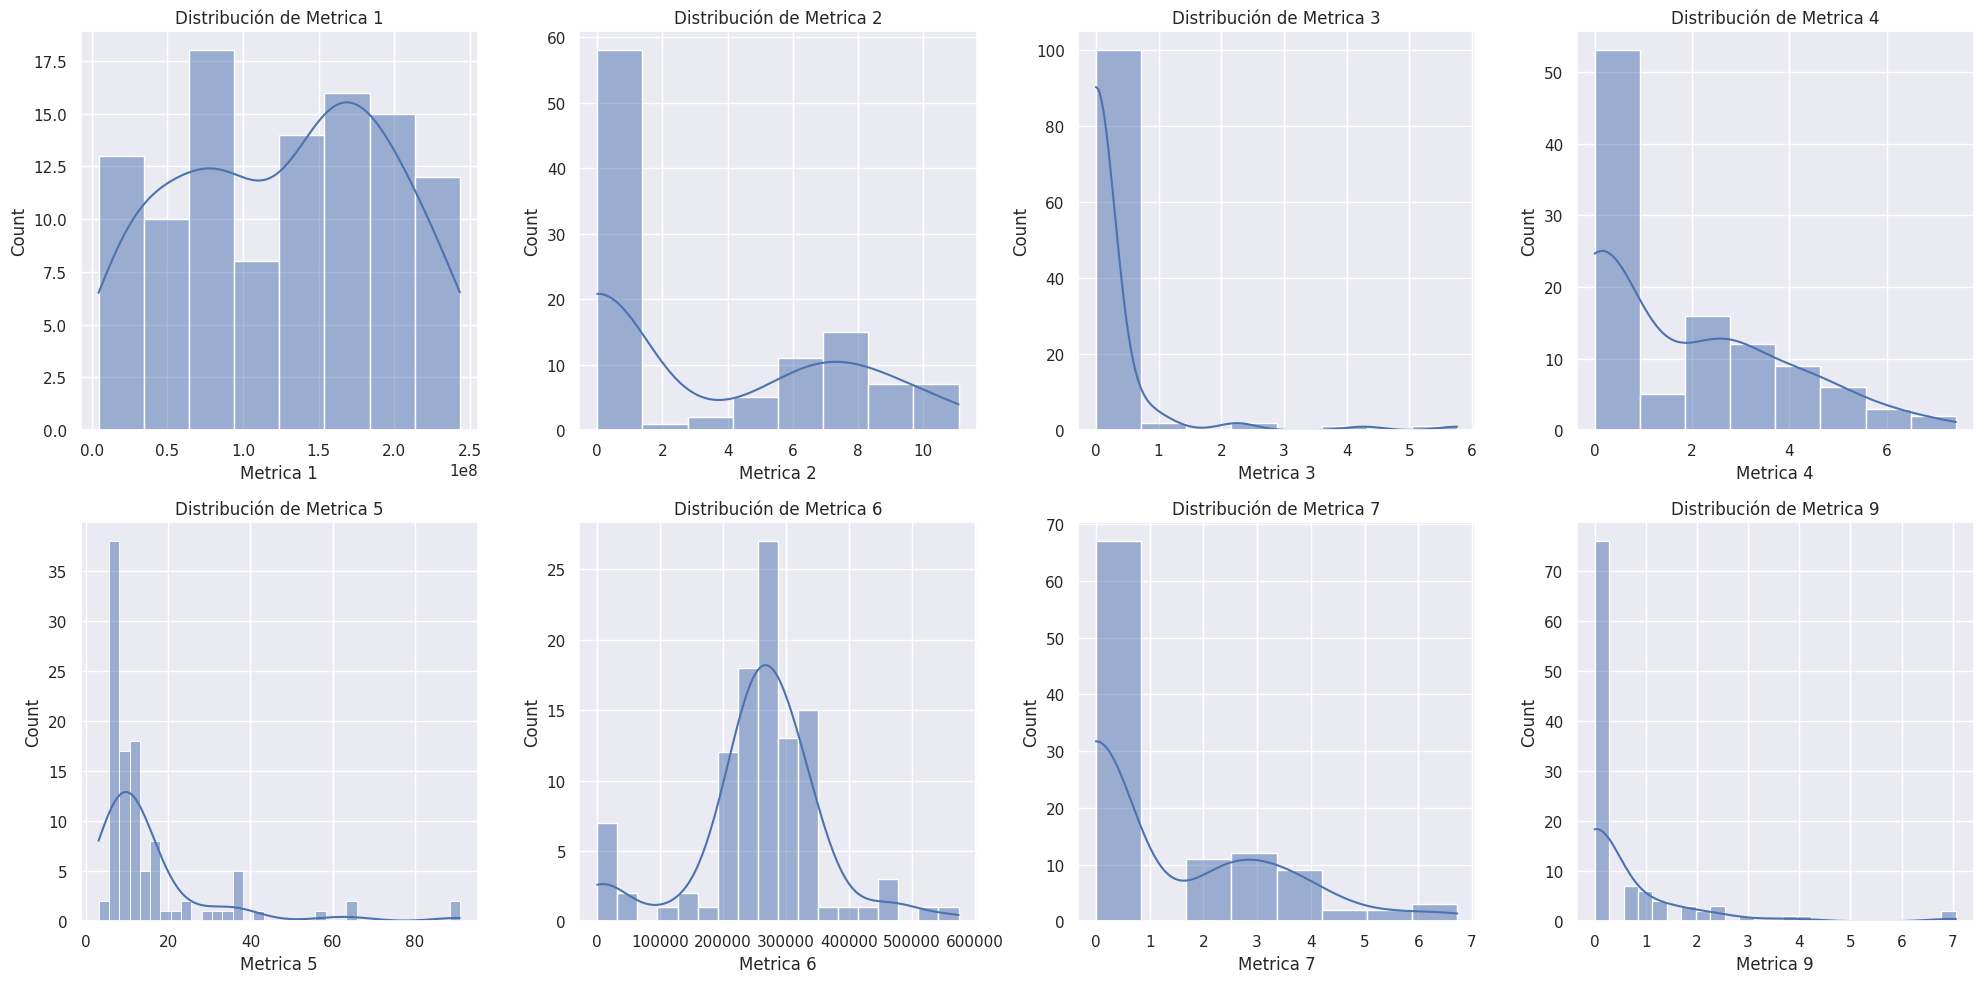

In [450]:
## Ahora las distribuciones para falla (failure=1)
plt.figure(figsize=(20, 10))
print("Distribución para fallas (failure = 1)")
mask = df.Falla > 0
for i, col in enumerate(['Metrica 1', 'Metrica 2', 'Metrica 3', 'Metrica 4', 'Metrica 5', 'Metrica 6', 'Metrica 7', 'Metrica 9']):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=df.loc[mask], x=col, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()

**Manejo de fechas**

Se transforma el formato de las fechas a uno que entregue formato manejable

Text(0.5, 1.0, 'Falla en el tiempo (meses)')

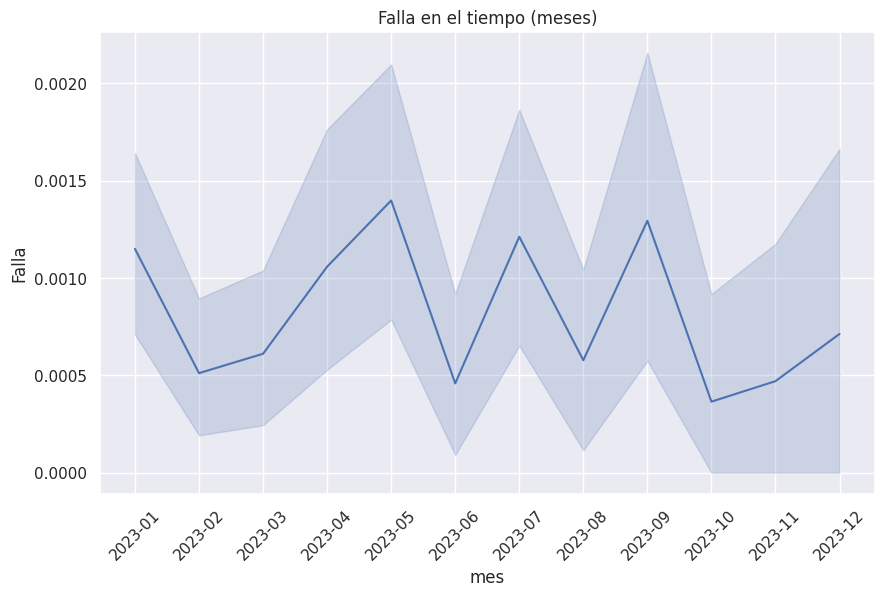

In [451]:
## Convierte 'date' a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

## Extrae y formatea el mes para graficar
df['mes'] = df['Fecha'].dt.to_period('M')
df['mes'] = df['mes'].dt.strftime('%Y-%m')

## Crea un gráfico de línea para visualizar 'failure' sobre los meses
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='mes', y='Falla')
plt.xticks(rotation=45)
plt.title("Falla en el tiempo (meses)")

In [452]:
df

,Fecha,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9,Modelo_Dispositivo,mes
0,2023-01-01,0,215630672,4.025352,0.000000,3.970292,6,407438,0.000000,2.079442,S1F0,2023-01
1,2023-01-01,0,61370680,0.000000,1.386294,0.000000,6,403174,0.000000,0.000000,S1F0,2023-01
2,2023-01-01,0,173295968,0.000000,0.000000,0.000000,12,237394,0.000000,0.000000,S1F0,2023-01
3,2023-01-01,0,79694024,0.000000,0.000000,0.000000,6,410186,0.000000,0.000000,S1F0,2023-01
4,2023-01-01,0,135970480,0.000000,0.000000,0.000000,15,313173,0.000000,1.386294,S1F0,2023-01
...,...,...,...,...,...,...,...,...,...,...,...,...
124237,2023-02-11,0,18310224,0.000000,0.000000,0.000000,10,353705,2.197225,0.000000,Z1F0,2023-02
124238,2023-02-11,0,172556680,4.574711,4.682131,1.609438,11,332792,0.000000,2.639057,Z1F0,2023-02
124239,2023-02-11,0,19029120,8.483223,0.000000,0.000000,11,350410,0.000000,0.000000,Z1F0,2023-02
124240,2023-02-11,0,226953408,0.000000,0.000000,0.000000,12,358980,0.000000,0.000000,Z1F0,2023-02


Text(0.5, 1.0, 'Fallas por semana')

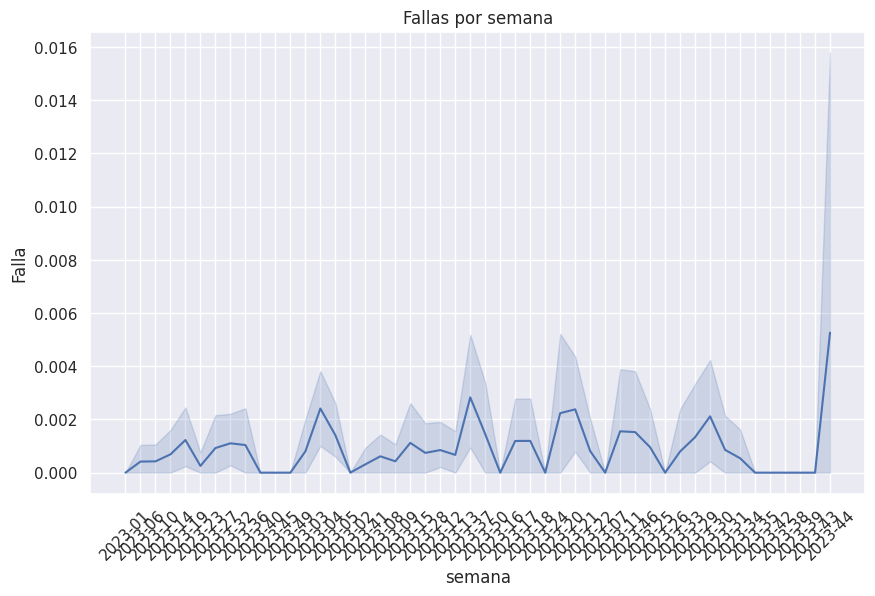

In [453]:
## Extrae y formatea la columna 'week'para graficar
df['semana'] = df['Fecha'].dt.to_period('W')
df['semana'] = df['semana'].dt.strftime('%Y-%U')

## Grafica las fallas por semana
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='semana', y='Falla')
plt.xticks(rotation=45)
plt.title("Fallas por semana")

Mostramos los nuevos datos que incluyen una columna o característica 'mes' y 'semana'

In [454]:
df

,Fecha,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9,Modelo_Dispositivo,mes,semana
0,2023-01-01,0,215630672,4.025352,0.000000,3.970292,6,407438,0.000000,2.079442,S1F0,2023-01,2023-01
1,2023-01-01,0,61370680,0.000000,1.386294,0.000000,6,403174,0.000000,0.000000,S1F0,2023-01,2023-01
2,2023-01-01,0,173295968,0.000000,0.000000,0.000000,12,237394,0.000000,0.000000,S1F0,2023-01,2023-01
3,2023-01-01,0,79694024,0.000000,0.000000,0.000000,6,410186,0.000000,0.000000,S1F0,2023-01,2023-01
4,2023-01-01,0,135970480,0.000000,0.000000,0.000000,15,313173,0.000000,1.386294,S1F0,2023-01,2023-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124237,2023-02-11,0,18310224,0.000000,0.000000,0.000000,10,353705,2.197225,0.000000,Z1F0,2023-02,2023-07
124238,2023-02-11,0,172556680,4.574711,4.682131,1.609438,11,332792,0.000000,2.639057,Z1F0,2023-02,2023-07
124239,2023-02-11,0,19029120,8.483223,0.000000,0.000000,11,350410,0.000000,0.000000,Z1F0,2023-02,2023-07
124240,2023-02-11,0,226953408,0.000000,0.000000,0.000000,12,358980,0.000000,0.000000,Z1F0,2023-02,2023-07


## Correlaciones entre datos

Sólo para aquellas columnas o características numéricas se calcula las correlaciones cruzadas existentes

Text(0.5, 1.0, 'Matriz de Correlación')

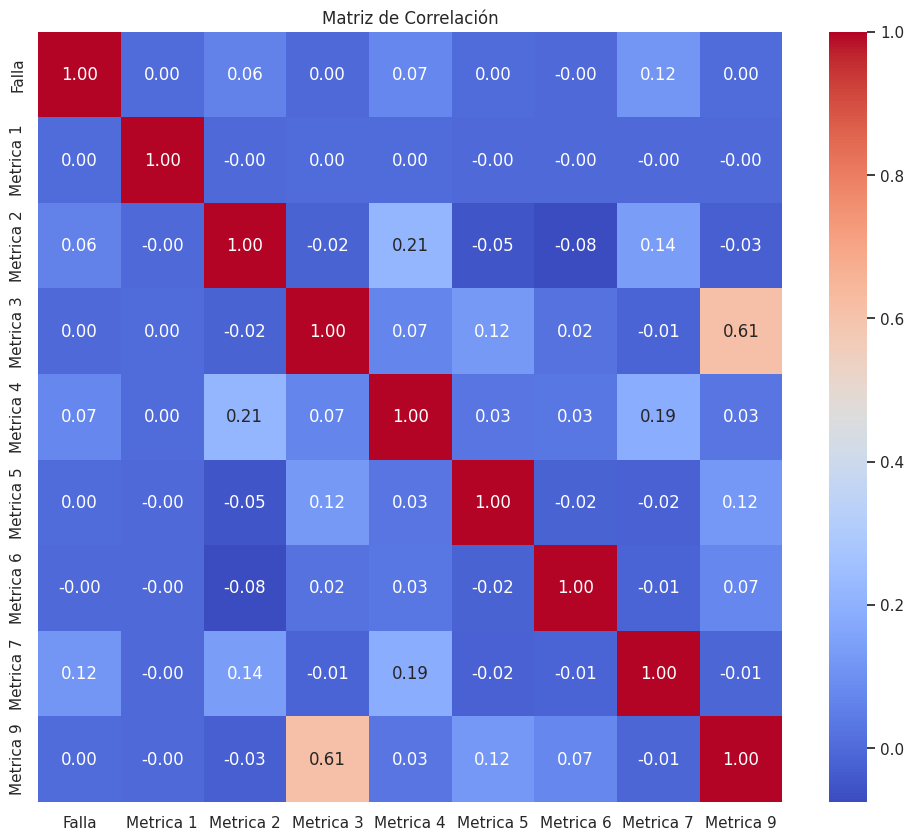

In [455]:
## Seleccionamos las columnas numéricas para la matriz de correlaciones
numeric_cols = df.select_dtypes(include=[np.number])

## Calcula la matriz de correlación
correlation_matrix = numeric_cols.corr()

## Crea un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de Correlación")

Dado que la falla es generalmente cero (no falla), buscar la correlación no sería eficiente

Text(0.5, 1.0, 'Distribución de falla')

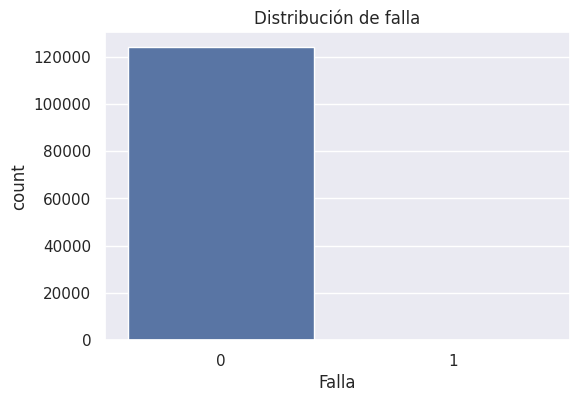

In [456]:
## Calculamos un gráfico de frecuencia de falla y no falla
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Falla')
plt.title("Distribución de falla")

Como es posible observar desde el gráfico la cantidad de no falla son muy superior a la cantidad de fallas en los datos. Esta situación de ser utilizada directamente traerí un problema de sub muestreo para el caso de las fallas.

Es razonable seguir con los datos tal cual como están?, para que situación sería razonable?


## Estudio de fallas

Queremos revisar si las fallas se dan en días específicos de las semana, fin de semana o días del mes. Para ello, creamos columnas o características adicionales que incluyan el día de la semana, el día del mes y si es fin de semana

In [457]:
## Obtenemos el día de la semana, día del mes y si es fin de semana desde
## la columna fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['dia_semana'] = df['Fecha'].dt.dayofweek
df['dia_mes'] = df['Fecha'].dt.day
df['fin_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)

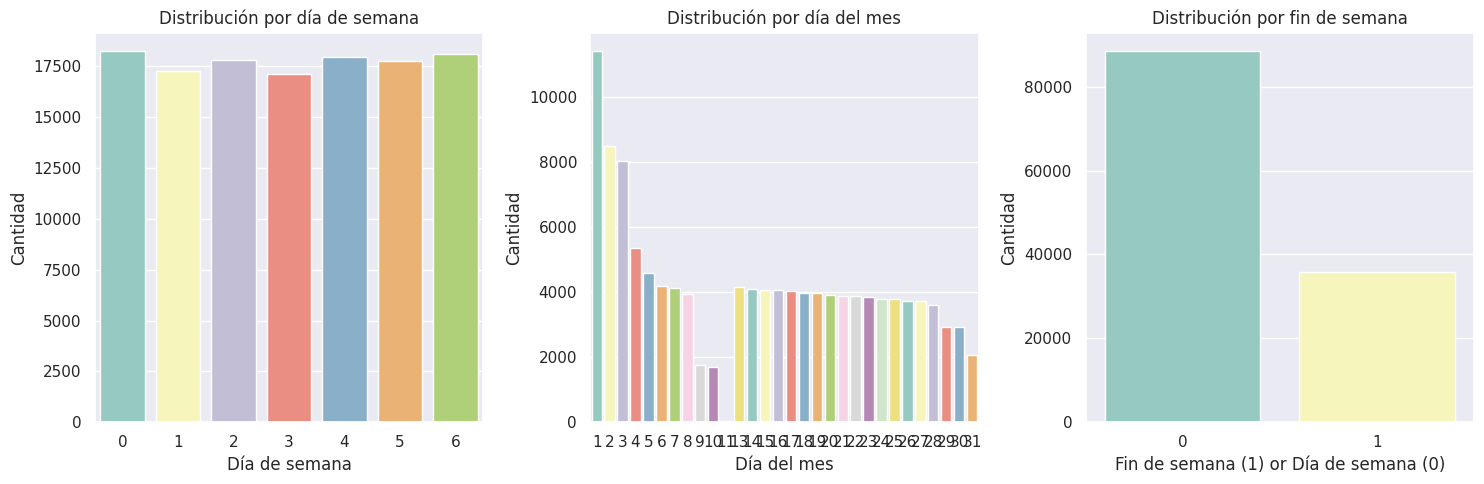

In [458]:
## Ahora creamos gráficos para visualizar las distribuciones de falla
## por día de la semana, día del mes y fin de semana
plt.figure(figsize=(15, 5))

## Distribución por día de la semana
plt.subplot(131)
sns.countplot(data=df, x='dia_semana', palette='Set3')
plt.title("Distribución por día de semana")
plt.xlabel("Día de semana")
plt.ylabel("Cantidad")

## Distribución por día del mes
plt.subplot(132)
sns.countplot(data=df, x='dia_mes', palette='Set3')
plt.title("Distribución por día del mes")
plt.xlabel("Día del mes")
plt.ylabel("Cantidad")

## Distribución por fin de semana
plt.subplot(133)
sns.countplot(data=df, x='fin_semana', palette='Set3')
plt.title("Distribución por fin de semana")
plt.xlabel("Fin de semana (1) or Día de semana (0)")
plt.ylabel("Cantidad")

## Muestra los gráficos
plt.tight_layout()
plt.show()

In [459]:
## Extraemos el número del mes y número de la semana y eliminamos 'date'
df['mes'] = df['Fecha'].dt.month
df['semana'] = df['Fecha'].dt.isocalendar().week
df = df.drop(['Fecha'], axis=1)

## Chequeamos los datos del nuevo dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124242 entries, 0 to 124241
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Falla               124242 non-null  int64  
 1   Metrica 1           124242 non-null  int64  
 2   Metrica 2           124242 non-null  float64
 3   Metrica 3           124242 non-null  float64
 4   Metrica 4           124242 non-null  float64
 5   Metrica 5           124242 non-null  int64  
 6   Metrica 6           124242 non-null  int64  
 7   Metrica 7           124242 non-null  float64
 8   Metrica 9           124242 non-null  float64
 9   Modelo_Dispositivo  124242 non-null  object 
 10  mes                 124242 non-null  int32  
 11  semana              124242 non-null  UInt32 
 12  dia_semana          124242 non-null  int32  
 13  dia_mes             124242 non-null  int32  
 14  fin_semana          124242 non-null  int64  
dtypes: UInt32(1), float64(5), int32(3)

In [460]:
## Para aplicar la codificación One Hot Encoding se utiliza la función pd.get_dummies()
## Cada variable se convierte en tantas variables 0/1 como valores diferentes haya.
## Las columnas de la salida reciben el nombre de un valor; si la entrada es un DataFrame,
## el nombre de la variable original se antepone al valor
## La opción drop_first indica que se deben sacar los dummies k-1 de los k niveles
## categóricos eliminando el primer nivel
df = pd.get_dummies(df,drop_first=True)
df

,Falla,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9,mes,semana,dia_semana,dia_mes,fin_semana,Modelo_Dispositivo_S1F1,Modelo_Dispositivo_W1F0,Modelo_Dispositivo_W1F1,Modelo_Dispositivo_Z1F0,Modelo_Dispositivo_Z1F1
0,0,215630672,4.025352,0.000000,3.970292,6,407438,0.000000,2.079442,1,52,6,1,1,False,False,False,False,False
1,0,61370680,0.000000,1.386294,0.000000,6,403174,0.000000,0.000000,1,52,6,1,1,False,False,False,False,False
2,0,173295968,0.000000,0.000000,0.000000,12,237394,0.000000,0.000000,1,52,6,1,1,False,False,False,False,False
3,0,79694024,0.000000,0.000000,0.000000,6,410186,0.000000,0.000000,1,52,6,1,1,False,False,False,False,False
4,0,135970480,0.000000,0.000000,0.000000,15,313173,0.000000,1.386294,1,52,6,1,1,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124237,0,18310224,0.000000,0.000000,0.000000,10,353705,2.197225,0.000000,2,6,5,11,1,False,False,False,True,False
124238,0,172556680,4.574711,4.682131,1.609438,11,332792,0.000000,2.639057,2,6,5,11,1,False,False,False,True,False
124239,0,19029120,8.483223,0.000000,0.000000,11,350410,0.000000,0.000000,2,6,5,11,1,False,False,False,True,False
124240,0,226953408,0.000000,0.000000,0.000000,12,358980,0.000000,0.000000,2,6,5,11,1,False,False,False,True,False


## Extración de valores aleatorios de datos

Debido al fuerte desbalance entre no fallas (124.388) y fallas (106) originalmente que se observó anteriormente, entonces muestreamos desde las filas de no falla un subconjunto que nos permita trabajar sin sesgo.

In [461]:
## Importanmos una librería de submuestreo aleatorio
from imblearn.under_sampling import RandomUnderSampler

In [462]:
## Crea una copia del dataframe 'df'
X = df.copy()

## Crea una copia de la variable 'Falla" en 'Y'
Y = df["Falla"]

## Elimina desde la copia 'X' la columna 'Falla'
X.drop("Falla", axis=1, inplace=True)

In [463]:
## Creamos una instancia de RandomUnderSampler con un valor para random state
rus = RandomUnderSampler(random_state=42)

## Realizamos el muestreo under-sampling y obtenemos las filas resampled de
## características 'X' y variable objetivo 'Y'
X_resampled, y_resampled = rus.fit_resample(X, Y)

In [464]:
## Creamos un nuevo dataframe 'under_sample' copiando las muestras resampled
## de las características y agregamos la columna 'failure'
under_sample = X_resampled.copy()
under_sample["failure"] = y_resampled

In [465]:
## Mostramos el nuevo data frame desde los datos under-sampled
under_sample.sample(10)

,Metrica 1,Metrica 2,Metrica 3,Metrica 4,Metrica 5,Metrica 6,Metrica 7,Metrica 9,mes,semana,dia_semana,dia_mes,fin_semana,Modelo_Dispositivo_S1F1,Modelo_Dispositivo_W1F0,Modelo_Dispositivo_W1F1,Modelo_Dispositivo_Z1F0,Modelo_Dispositivo_Z1F1,failure
117481,190150856,0.0,0.0,0.000000,8,296375,0.000000,0.000000,5,19,1,9,0,False,False,True,False,False,0
95355,158078864,0.0,0.0,0.000000,9,220584,0.000000,0.693147,6,25,4,23,0,False,False,True,False,False,0
101571,198736232,0.0,0.0,2.833213,16,336698,0.000000,0.000000,11,45,1,7,0,False,True,False,False,False,1
97924,178051496,0.0,0.0,0.000000,7,265316,0.000000,0.000000,6,26,4,30,0,False,False,False,False,True,1
58742,213812216,0.0,0.0,3.258097,16,335299,0.000000,0.000000,3,12,2,22,0,True,False,False,False,False,0
6063,162100200,0.0,0.0,0.000000,13,239630,0.000000,0.000000,6,22,3,1,0,False,False,False,False,False,0
8243,183820824,0.0,0.0,0.000000,11,35,0.000000,0.000000,8,31,1,1,0,False,False,True,False,False,0
71766,85391744,0.0,0.0,0.000000,11,481762,0.000000,0.000000,4,16,1,18,0,False,False,False,True,False,0
60211,7660592,0.0,0.0,0.000000,8,264617,2.197225,0.000000,3,12,4,24,0,False,True,False,False,False,1
119590,83698296,0.0,0.0,0.000000,10,507356,0.000000,0.000000,9,38,1,19,0,False,False,False,True,False,0


In [466]:
under_sample.shape

(212, 19)

Notamos que la cantidad de datos disponibles para el trabajo de modelos de ML supervisados es de sólo 212 filas, pero esto debería dar una muestra equilibrada de los datos

Text(0.5, 1.0, 'Distribución de las fallas')

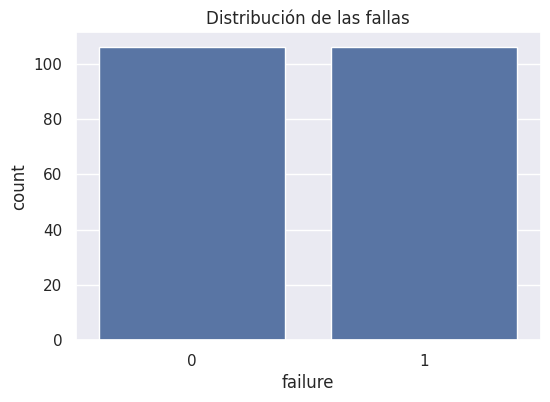

In [467]:
## Finalmente, graficamos las no fallas y fallas en un gráfico de frecuencia
## desde el nuevo dataframe under-sampled
plt.figure(figsize=(6, 4))
sns.countplot(data=under_sample, x='failure')
plt.title("Distribución de las fallas")

Observamos ahora una muestra equitativa entre las no fallas y fallas

# Modelo de ML

Dado que tenemos los datos que nos permiten construir modelos de ML, entonces procedemos a construirlos.

Desde los datos (under_sample) lo que debemos hacer es separar los datos en aquellos que se utilizarán para el entrenamiento de los diversos modelos (x_train e y_train) que representarán un 20% de todos los datos disponibles (212 filas), y aquellos de validación o testeo (x_test e y_test). Para tales efectos se utiliza la librería train_test_split.

En forma adicional, y de manera de eliminar los efectos de escalas diferentes de los datos, se utiliza un"escalador" que tiene por objetivo escalar los datos de manera de hacerlos comparables en escala. Para tales efectos se utiliza la libería StandarScaler

In [468]:
## Importamos las librería necesarias para crear los datos de los modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Separamos los datos en 'caracteríasticas'y 'variable a explicar'
X_norm = under_sample.drop(['failure'], axis=1)
y_norm = under_sample['failure']

## Separamos los datos en entrenamiento (train) y validación (test)
x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

## Ahora, realizamos el escalamiento de los datos de entrenamiento y test
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [469]:
under_sample.columns

Index(['Metrica 1', 'Metrica 2', 'Metrica 3', 'Metrica 4', 'Metrica 5',
       'Metrica 6', 'Metrica 7', 'Metrica 9', 'mes', 'semana', 'dia_semana',
       'dia_mes', 'fin_semana', 'Modelo_Dispositivo_S1F1',
       'Modelo_Dispositivo_W1F0', 'Modelo_Dispositivo_W1F1',
       'Modelo_Dispositivo_Z1F0', 'Modelo_Dispositivo_Z1F1', 'failure'],
      dtype='object')

**Importamos la librería para los modelos**

In [470]:
## Importamos las librerías de los modelo de clasificación de ML
from sklearn.naive_bayes import GaussianNB, BernoulliNB
#######from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression #####, SGDClassifier
from sklearn.ensemble import RandomForestClassifier #####, GradientBoostingClassifier, , AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Creamos los modelos**

In [471]:
## Define una función con diferentes clasificadores y retorna
## un dataframe con las métricas de evaluación
def evaluate_model(x_train, y_train, x_test, y_test):
    ## Lista de clasificadores a utilizar
    classifiers = [
        RandomForestClassifier(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        GaussianNB(),
        BernoulliNB(),
        SVC(),
        LogisticRegression(),
    ]

    ## Define los nombre de los clasificadores
    classifier_names = [
        'RandomForest',
        'DecisionTree',
        'KNeighbors',
        'GaussianNB',
        'BernoulliNB',
        'SVC',
        'LogisticRegression',
    ]
    ## Crea una dataframe vacío para las métricas
    metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=classifier_names)

    ## Evalúa cada clasificador y almacena las métricas
    for i, clf in enumerate(classifiers):
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        metrics.loc[classifier_names[i], 'Accuracy'] = accuracy
        metrics.loc[classifier_names[i], 'Precision'] = precision
        metrics.loc[classifier_names[i], 'Recall'] = recall
        metrics.loc[classifier_names[i], 'F1'] = f1

    ## Ordena las métricas por exactitud (accuracy) en orden descendente
    metrics = metrics.sort_values(by='Accuracy', ascending=False)

    return metrics

In [472]:
## Paso 4: Llama a la función para evaluar los modelos
metrics = evaluate_model(x_train, y_train, x_test, y_test)

In [473]:
metrics

,Accuracy,Precision,Recall,F1
SVC,0.860465,1.0,0.75,0.857143
RandomForest,0.837209,0.904762,0.791667,0.844444
GaussianNB,0.837209,0.947368,0.75,0.837209
LogisticRegression,0.837209,0.904762,0.791667,0.844444
BernoulliNB,0.813953,0.9,0.75,0.818182
DecisionTree,0.744186,0.782609,0.75,0.765957
KNeighbors,0.72093,0.928571,0.541667,0.684211


# Instalamos optuna

Optuna es un marco de software de optimización automática de hiperparámetros, especialmente diseñado para el aprendizaje automático

Referencia: https://optuna.readthedocs.io/en/stable/

In [474]:
!pip install optuna -q

In [475]:
import optuna

In [476]:
## Crea un objeto de Optuna Study
def create_study(objective):

    ## Establezca el nivel de registro en ADVERTENCIA para suprimir la salida innecesaria
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize')  # We want to maximize accuracy

    ## Corra la optimización
    study.optimize(objective, n_trials=100)  ## Es posible ajustar en número de intentos

    # Obtenga los mejores hiperparámetros
    best_params = study.best_params
    best_f1 = study.best_value
    print(f'Best hyperparameters: {best_params}')
    print(f'Best f1 score: {best_f1}')
    return best_params

# Random Forest

In [477]:
## Define la función objetivo a optimizar
def objective_rf(trial):
    ## Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_uniform('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_uniform('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['log2', 'sqrt'])

    ## Crear y entrenar el RandomForestClassifier con los hiperparámetros sugeridos
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    ## Entrene el clasificardor con datos de entrenamiento
    clf.fit(x_train, y_train)

    ## Haga la predicción con datos de testeo
    y_pred = clf.predict(x_test)

    ## Calcule el F1-Score como objetivo a maximizar
    f1 = f1_score(y_test, y_pred)

    return f1

In [478]:
## Cree el objeto para Random Forest
best_params = create_study(objective_rf)
## Ajuste con los hiperparámetros
best_rf = RandomForestClassifier(**best_params, random_state=42)
## Obtenga el mejor
y_pred_rf = best_rf.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'n_estimators': 38, 'max_depth': 22, 'min_samples_split': 0.5131823967257934, 'min_samples_leaf': 0.10061931767219877, 'max_features': 'log2'}
Best f1 score: 0.8444444444444444


# Árbol de desción

In [479]:
## Define la función objetivo a optimizar
def objective_dt(trial):
    ## Define los hiperparámetros y rangos
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 4, 32, log=True)
    min_samples_split = trial.suggest_uniform('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_uniform('min_samples_leaf', 0.1, 0.5)

    ## Crea el clasificardor DecisionTree con los hiperparámetros sugeridos
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  # Set a random state for reproducibility
    )

    ## Ajusta el clasificador con datos de entrenamiento
    clf.fit(x_train, y_train)

    ## Predice con datos de testeo
    y_pred = clf.predict(x_test)

    ## Calcula el F1-Score con función objetivo
    f1 = f1_score(y_test, y_pred)

    return f1

In [480]:
best_params = create_study(objective_dt)
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
y_pred_dt = best_dt.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 0.6986444212767833, 'min_samples_leaf': 0.36582665434695766}
Best f1 score: 0.6909090909090909


In [504]:
import graphviz
from sklearn import tree

text_representation = tree.export_text(best_dt)
print(text_representation)

|--- feature_10 <= -0.32
|   |--- class: 0
|--- feature_10 >  -0.32
|   |--- class: 1



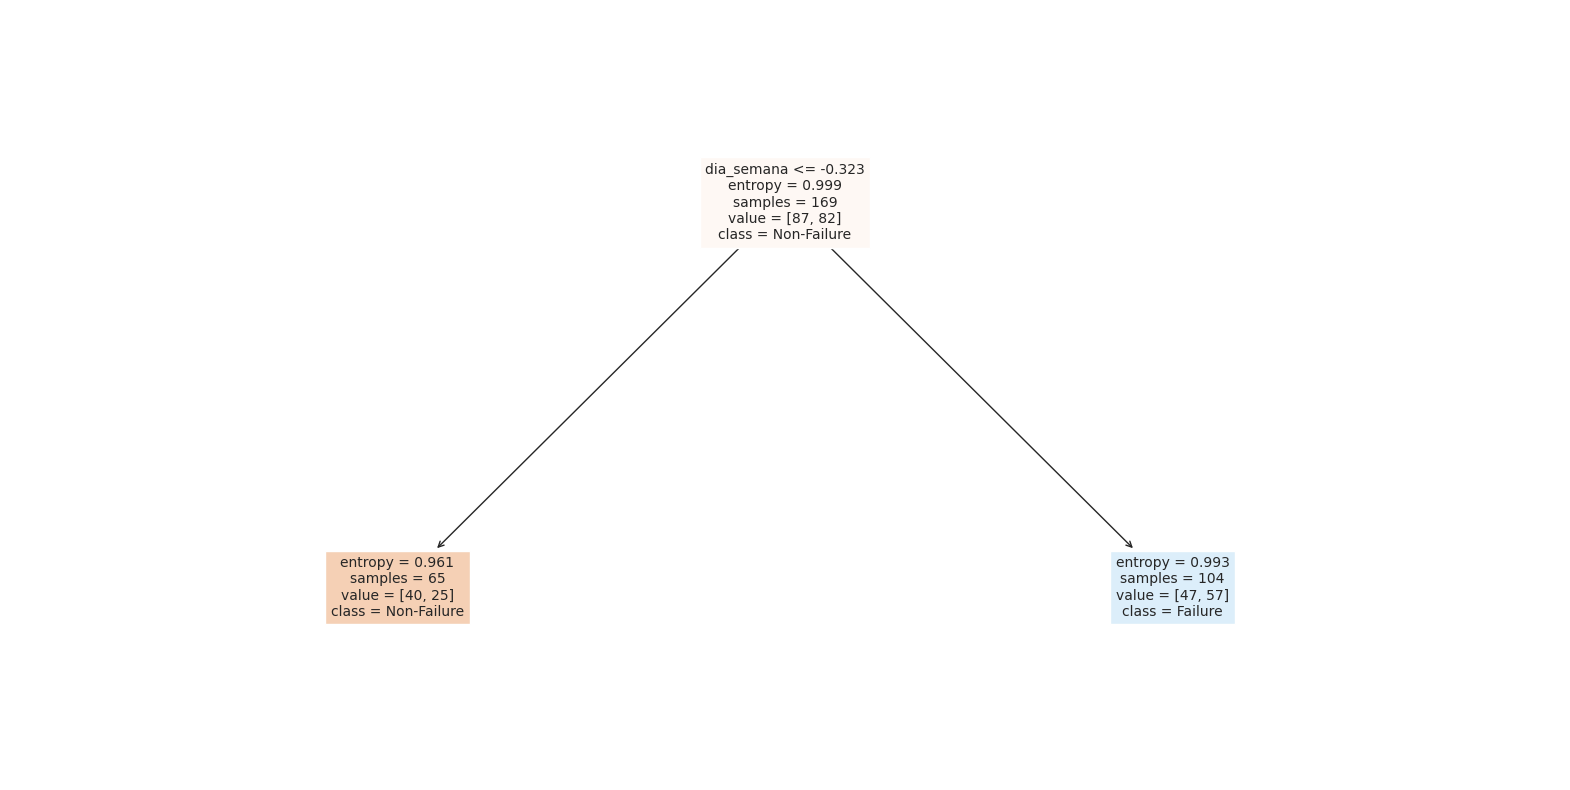

In [505]:
## Dibijamos el árbol seleccionado
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Grafica el árbol
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=df.drop("Falla",axis=1).columns.to_list(), class_names=["Non-Failure", "Failure"], filled=True, fontsize=10)
plt.show()

# Vecino más Cercano (K Neighbors Classifier)

In [482]:
def objective_knn(trial):
    ## Define los hiperparámetros
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),  ## p=1 para la distancia tipo Manhattan distance,
                                            ## p=2 para la distancia Euclidiana
    }

    ## Inicializa el clasificador con los hiperparámetros
    clf = KNeighborsClassifier(**params)

    ## Entrena el clasificador con los datos de entrenamiento
    clf.fit(x_train, y_train)

    ## Predice con los datos de test
    y_pred = clf.predict(x_test)

    ## Calcula el F1-Score como función objetivo a maximizar
    f1 = f1_score(y_test, y_pred)

    return f1

In [483]:
best_params=create_study(objective_knn)
best_knn = KNeighborsClassifier(**best_params)
y_pred_knn = best_knn.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}
Best f1 score: 0.7142857142857143


# Naive Bayes

In [484]:
best_gnb = GaussianNB()
y_pred_gnb = best_gnb.fit(x_train, y_train).predict(x_test)

# BernoulliNB

In [485]:
def objective_bnb(trial):
    # Define hyperparameters to optimize
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-10, 1.0),
        'binarize': trial.suggest_float('binarize', 0.0, 1.0),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False]),
    }

    # Initialize the classifier with hyperparameters
    clf = BernoulliNB(**params)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(x_test)


    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [486]:
best_params=create_study(objective_bnb)
best_bnb = BernoulliNB(**best_params)
y_pred_bnb=best_bnb.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'alpha': 0.002111887206256756, 'binarize': 0.837468762773932, 'fit_prior': False}
Best f1 score: 0.8571428571428571


# Support Vector Machine (SVC)

In [487]:
def objective_svc(trial):
    ## Define los hiperparámetros para optimizar
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5) if trial.params['kernel'] == 'poly' else 1,
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']) if trial.params['kernel'] in ['rbf', 'poly', 'sigmoid'] else 'scale',
    }

    ## Inicializa el clasificar con los hiperparámetros
    clf = SVC(**params, random_state=42)

    ## Entrena el clasificador con los datos de entrenamiento
    clf.fit(x_train, y_train)

    ## hace predicciones con datos de testeo
    y_pred = clf.predict(x_test)

    ## Calcula el F1-Score como el objetivo a optimizar
    f1 = f1_score(y_test, y_pred)

    return f1

In [488]:
best_params=create_study(objective_svc)
best_svc = SVC(**best_params)
y_pred_svc = best_svc.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'C': 0.19281076716773785, 'kernel': 'linear'}
Best f1 score: 0.8571428571428571


# Regresión Logística

In [489]:
def objective_lr(trial):
    ## Define los hiperparámetros para optimizar
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
    }

    ## Inicializa el clasificador con los hiperparámetros
    clf = LogisticRegression(**params, random_state=42)

    ## Entrena el classificador con datos de entrenamiento
    clf.fit(x_train, y_train)

    ## predice con los datos de testeo
    y_pred = clf.predict(x_test)

    ## Calcula el F1-Score como la función a optimizar
    f1 = f1_score(y_test, y_pred)

    return f1

In [490]:
best_params=create_study(objective_lr)
best_lr = LogisticRegression(**best_params)
y_pred_lr = best_lr.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'C': 156.54218581514613, 'solver': 'liblinear'}
Best f1 score: 0.8444444444444444


# Comparación entre modelos

In [491]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Función para calcular las métricas
def calculate_evaluation_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

## Función que muestra la matriz de confusión
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", cbar=False, xticklabels=["Non-Failure", "Failure"], yticklabels=["Non-Failure", "Failure"], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)


Model: Model Random Forest
Precision: 0.9048
Recall: 0.7917
F1 Score: 0.8444
Accuracy: 0.8372

Model: Decison Tree
Precision: 0.6129
Recall: 0.7917
F1 Score: 0.6909
Accuracy: 0.6047

Model: KNN
Precision: 0.8333
Recall: 0.6250
F1 Score: 0.7143
Accuracy: 0.7209

Model: GaussianNB
Precision: 0.9474
Recall: 0.7500
F1 Score: 0.8372
Accuracy: 0.8372

Model: BernoulliNB
Precision: 1.0000
Recall: 0.7500
F1 Score: 0.8571
Accuracy: 0.8605

Model: SVC
Precision: 1.0000
Recall: 0.7500
F1 Score: 0.8571
Accuracy: 0.8605

Model: LogisticRegression
Precision: 0.9048
Recall: 0.7917
F1 Score: 0.8444
Accuracy: 0.8372


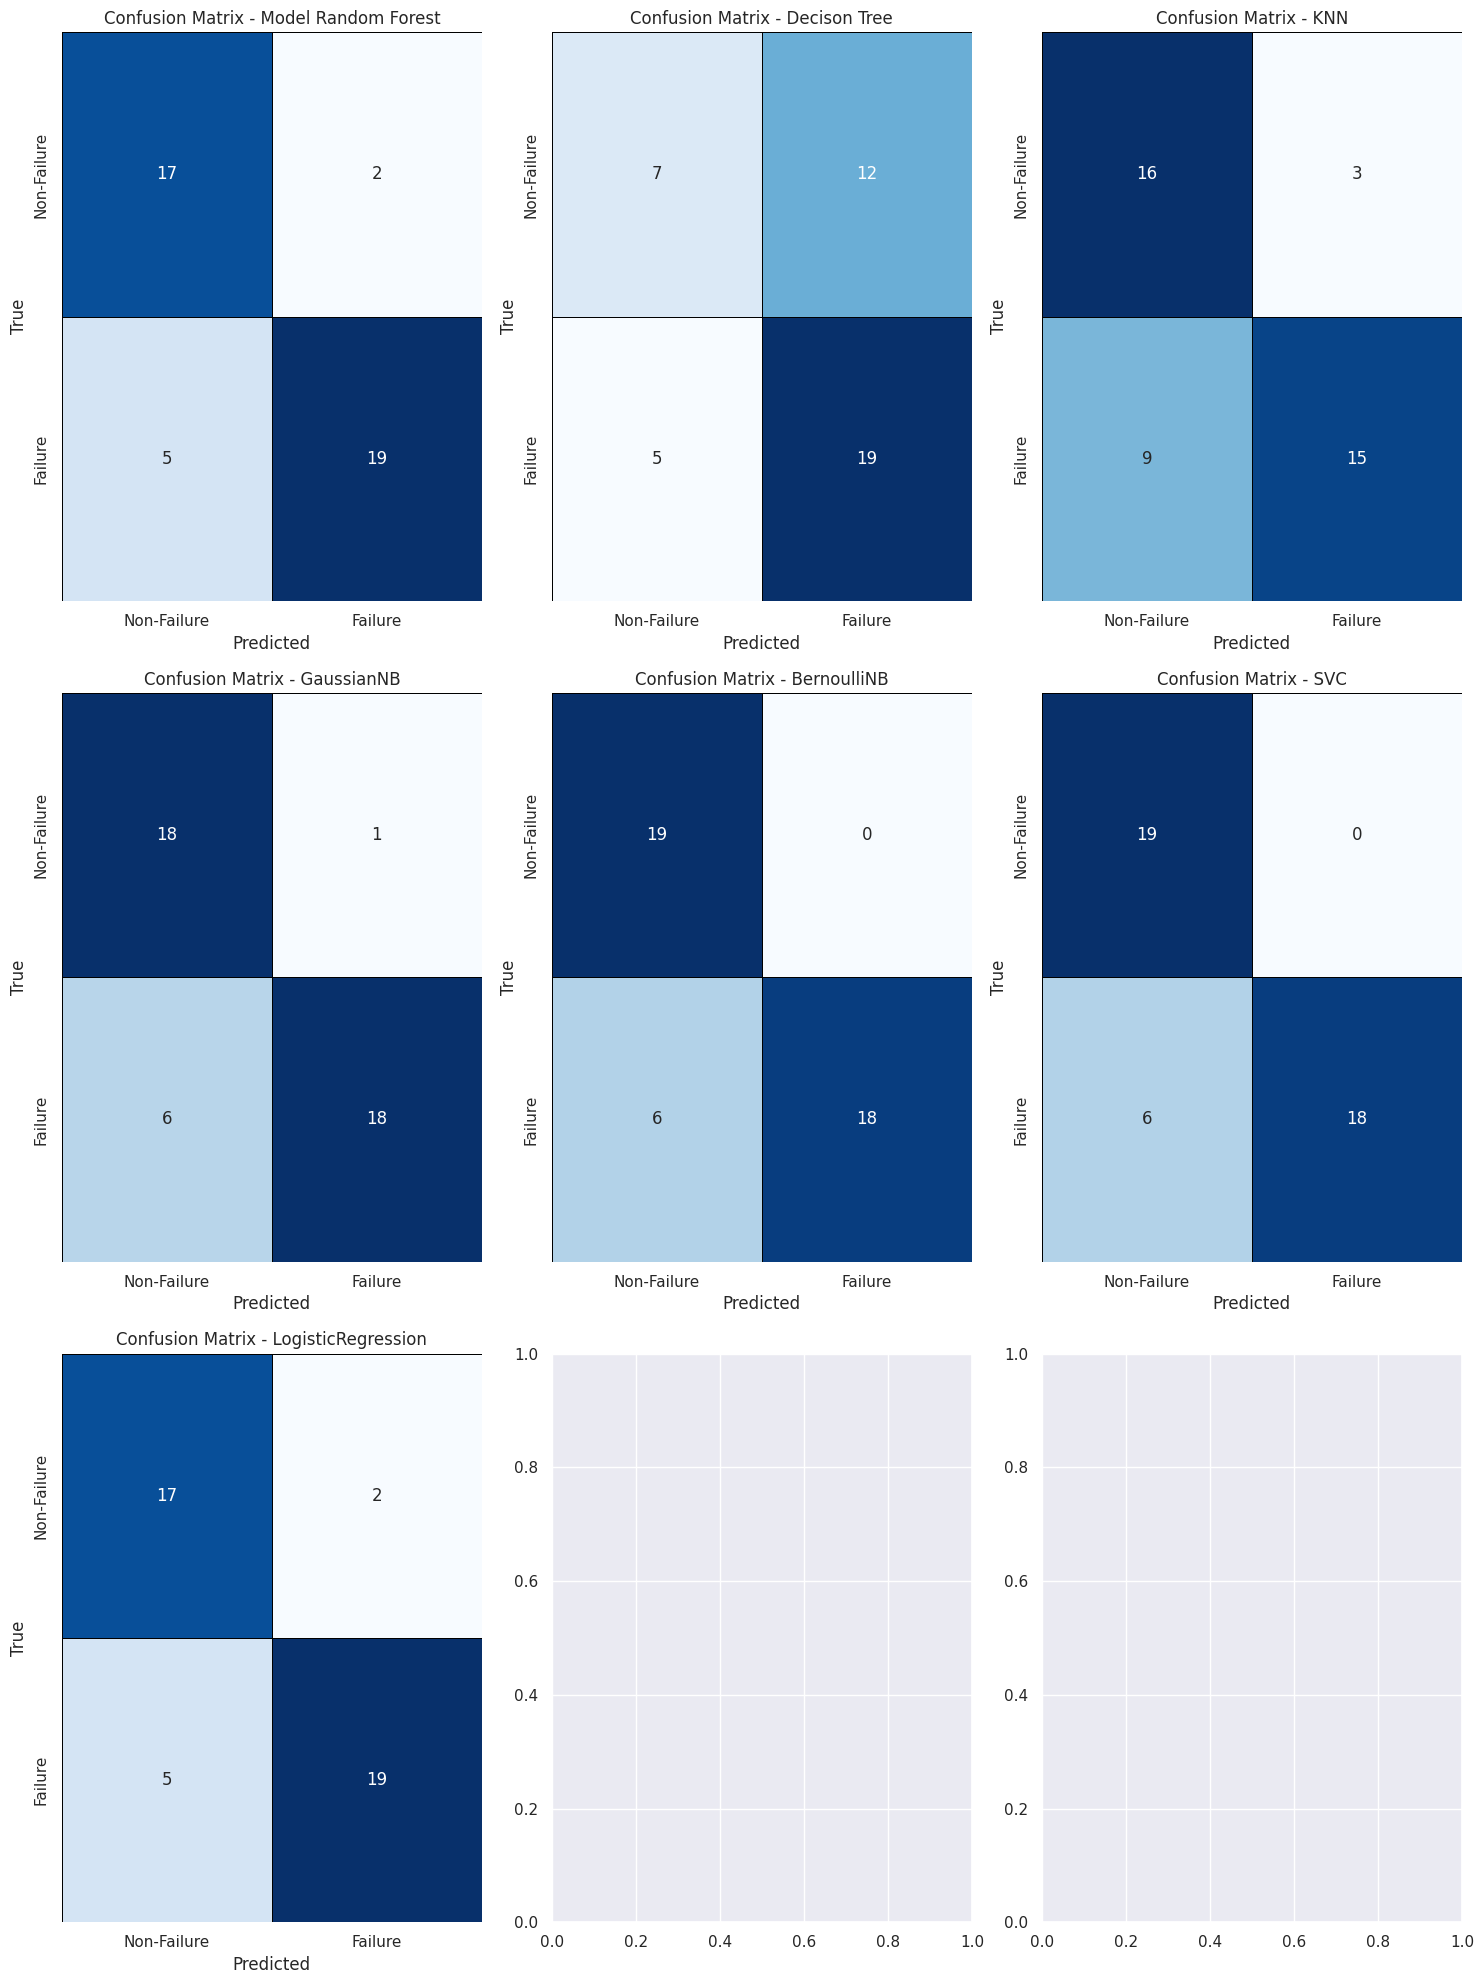

In [492]:
## Inicializa las variables para la mejor métrica
best_model = ""
best_f1 = 0.0
best_precision = 0.0
best_recall = 0.0
best_accuracy = 0.0

## Crea subgráficos de 2x2 (matriz de confusión)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(3*5, 4*5))

## Grafica para cada modelo la matriz de confusión
models = [
    ("Model Random Forest", y_pred_rf),
    ("Decison Tree", y_pred_dt),
    ("KNN", y_pred_knn),
    ("GaussianNB", y_pred_gnb),
    ("BernoulliNB",y_pred_bnb),
    ("SVC", y_pred_svc),
    ("LogisticRegression", y_pred_lr),
]

for (model_name, y_pred), ax in zip(models, axes.flatten()):
    plot_confusion_matrix(ax, y_test, y_pred, f"Confusion Matrix - {model_name}")

    ## Calcula la evaluación de métricas
    precision, recall, f1, accuracy = calculate_evaluation_metrics(y_test, y_pred)

    ## Imprime las métricas para cada modelo
    print(f"\nModel: {model_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    ## Actualiza el mejor modelo basado en el F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_model = model_name
        best_precision = precision
        best_recall = recall
        best_accuracy = accuracy

## Muestra los gráficos
plt.tight_layout()
plt.show()

In [493]:
## Imprime el mejor modelo de acuerdo al F1-Score
print("\n *** Mejor Modelo encontrado ***\n")
print(f"Modelo: {best_model}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")
print(f"Accuracy: {best_accuracy:.4f}")


 *** Mejor Modelo encontrado ***

Modelo: BernoulliNB
Precision: 1.0000
Recall: 0.7500
F1 Score: 0.8571
Accuracy: 0.8605


# Curva ROC

Una curva característica operativa del receptor , o curva ROC , es un gráfico que ilustra el rendimiento de un modelo de clasificador binario (también puede usarse para clasificación de múltiples clases) en valores de umbral variables.

La curva ROC es el gráfico de la tasa de verdaderos positivos (TPR) frente a la tasa de falsos positivos (FPR) en cada ajuste de umbral.

AUC: 0.8486842105263158


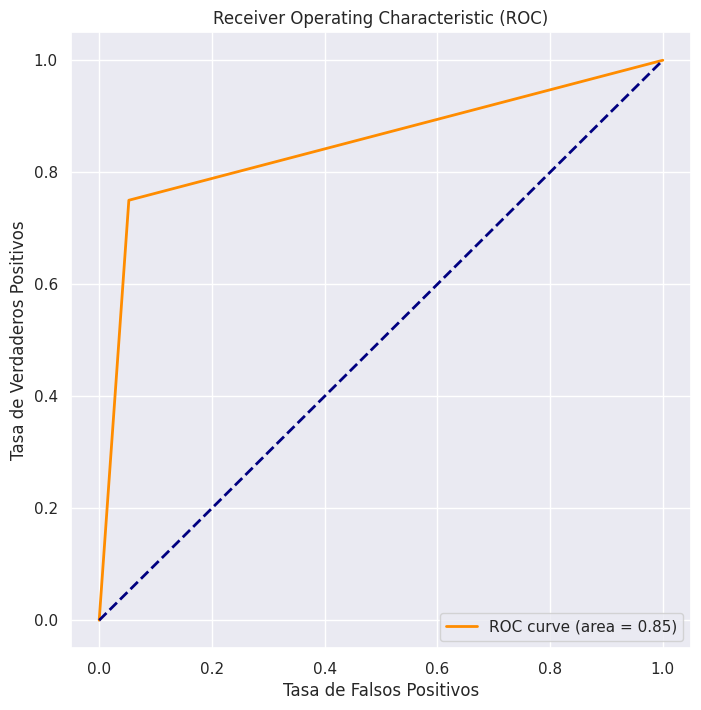

In [494]:
from sklearn.metrics import roc_curve, auc
## Se utiliza el modelo Gaussian Naive (y_pred_gnb)
## Podrían utilizarse otros modelos tales como
## - Árbol de decisión: y_pred_dt
## - Random Forest: y_pred_rf
## - SVC: y_pred_svc
##
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gnb) ##y_pred_bnb) ##y_pred_gnb)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'lower right')
plt.show()

# Evaluación de relevancia de caracterísíticas

La importancia de las características es un concepto del aprendizaje automático que se refiere a la importancia relativa o contribución de cada variable de entrada (también conocida como características o predictores) en la predicción de la variable o resultado objetivo

Puede reducir la cantidad de características en el modelo al ayudarnos a concentrarnos en las características de mayor importancia, reduciendo directamente los costos y el tiempo de capacitación e inferencia

Existen diferentes métodos para calcular la importancia de las características, los cuales van desde métodos muy rudimentarios hasta algoritmos bastante sofisticados

REF https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660

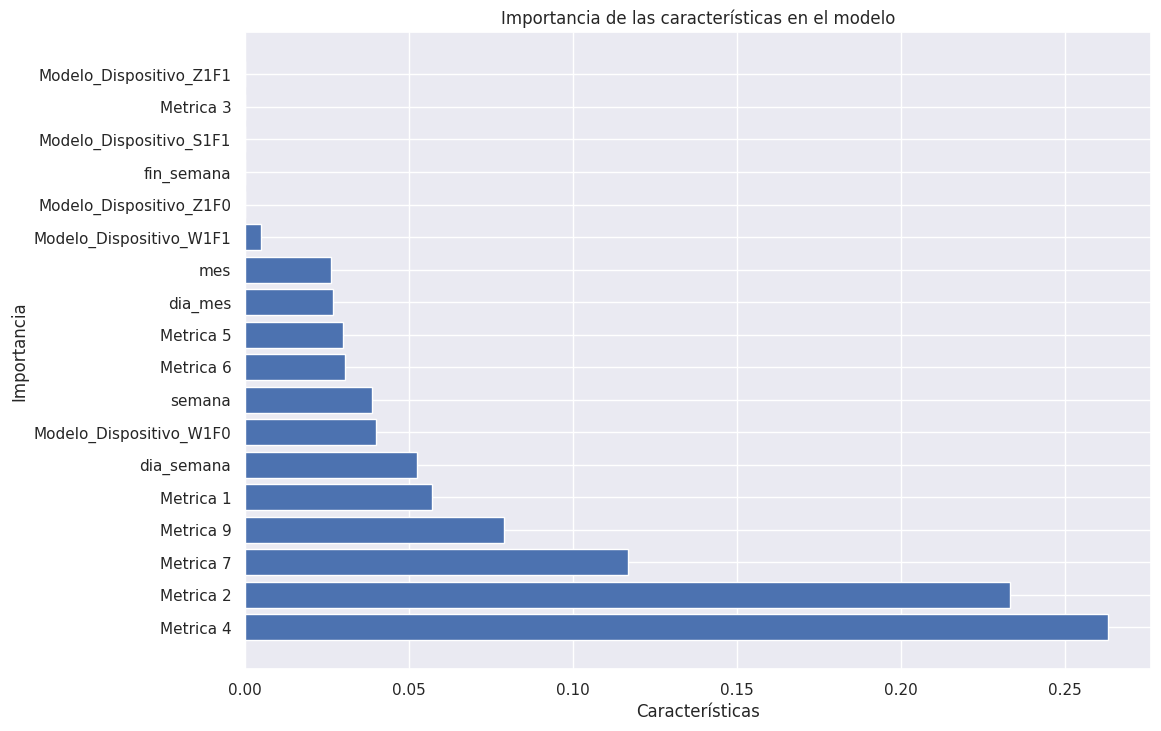

In [495]:
# Print the feature importances
feature_importances = best_rf.feature_importances_
##import seaborn as sns

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names =  np.array(under_sample.columns[sorted_indices])         ##under_sample.feature_names[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

##print(sorted_importances)
##print(sorted_feature_names)

plt.barh(sorted_feature_names, sorted_importances)
plt.title('Importancia de las características en el modelo')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()

# Cómo realizamos predicciones?

En esta sección tomaremos un modelo ya optimizado con desde el punto de vista de los hioperparámetros y haremos predicciones para que nos indique si habrá o no falla.

Para ello, seleccionamos. un modelo, por ejemplo tomamos el de Naive Bayes y le presentamos un posible escenario, es decir, un conjunto de métricas para que nos diga si hay falla (1) o no hay falla (0).

Hay que notar que los valores que le entregemos deben estar escalados para que los entienda como válidos


Datos a ingresar

- Metrica 1 -> 241295360
- Metrica 2 -> 0.000000
- Metrica 3 -> 0.000000
- Metrica 4 -> 0.000000
- Metrica 5 -> 6
- Matrica 6 -> 305202
- Metrica 7 -> 0.000000
- Metrica 9 -> 0.000000
- mes -> 2
- semana -> 8
- dia_semana -> 2
- dia_mes -> 22  
- fin_semana -> 0
- Modelo_Dispositivo_S1F1 -> False
- Modelo_Dispositivo_W1F0 -> True
- Modelo_Dispositivo_W1F1 -> False
- Modelo_Dispositivo_Z1F0 -> False
- Modelo_Dispositivo_Z1F1 -> False

In [496]:
## Cosntruimos el objeto de dato de entrada
x_check = np.array([241295360, 0.0, 0.0, 0.0, 6, 305202, 0.0, 0.0, 2, 8, 2, 22, 0, False, True, False, False, False])

## Ajuste de las métricas 2, 3, 4, 5, 6, 7 y 9
x_check[1]= np.log1p(x_check[1])
x_check[2]= np.log1p(x_check[2])
x_check[3]= np.log1p(x_check[3])
x_check[4]= np.log1p(x_check[4])
x_check[5]= np.log1p(x_check[5])
x_check[6]= np.log1p(x_check[6])

## Hacemos el reshape para tener el formato correcto
x_check = x_check.reshape(1,-1)

## Escalamos el datos para tenerlo en lo que revisó el modelo
scaler = StandardScaler()
x_valores = scaler.fit_transform(x_check)
x_test = scaler.transform(x_test)

## Realizamos la predicción
y_pred_gnb = best_gnb.predict(x_valores)

## Imprimimos la predicción
print('Posibilidad de falla', y_pred_gnb[0])

Posibilidad de falla 1


# Guardando y recuperando el modelo

In [497]:
import joblib
joblib.dump(best_gnb, path+'modeloNB')


['/content/drive/MyDrive/AA - Salfa/Casos/modeloNB']

In [498]:
print(path)

/content/drive/MyDrive/AA - Salfa/Casos/


In [499]:
model2 = joblib.load(path+'modeloNB')

val = model2.predict(x_valores)
print('Posibilidad de falla', val[0])

Posibilidad de falla 1
